In [14]:
prep_window <- function(rc = c(1,1), w = 4, h = 4, ...) { options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, ...) }

gcols = c("obs" = adjustcolor("blue", 0.5),
          "obs_synth" = "blue",
          "models" = adjustcolor("red", 0.5),
          "model_synth" = "red",
          "synth" = "magenta")

## Load data

In [29]:
fnm <- "minisynth"

# load data
df_in = read.csv(paste0(fnm,"_in.txt"), comment.char = "#", header = F, sep = " ")
colnames(df_in) <- c("y0", "y1", "est", "lower", "upper", "ci", "model", "m2", "m3")
obs_in = df_in[1:3,]
models_in = df_in[4:nrow(df_in),]

# also load synthesis produced by Climate Explorer for comparison
df_out <- read.fwf(paste0(fnm,"_out.txt"), comment.char = "#", header = F, widths = c(5,5,12,12,12,12,13,2,99))
df_out <- df_out[!is.na(df_out$V8),]
colnames(df_out) <- c("y0", "y1", "est", "lower", "upper", "l_wb", "u_wb", "group", "model")

obs_out <- df_out[df_out$group == 1,]
obs_synth <- df_out[df_out$group == 2,]
models_out <- df_out[df_out$group == 3,]
models_synth <- df_out[df_out$group == 4,]
overall_synth <- df_out[df_out$group == 5,]

nobs <- nrow(obs_in)
nmod <- nrow(models_in)

rep_unc <- 0.681
chi2_dof <- switch(fnm, "synthesis" = 11.85, "minisynth" = 44.28)         
mdl_unc <- switch(fnm, "synthesis" = 2.09, "minisynth" = 3.97)

## Mean & uncertainties of observations

Original Fortran code:
```fortran
!   compute mean & uncertainties of observations
!
    if ( nobs > 0 ) then
!       natural variability: assume 100% correlated
        do j=1,3
            s1 = 0
            do i=1,nobs
                s1 = s1 + data(j,i)
            end do
            obs(j) = s1/nobs
        end do

!       representation error from scatter of mean
        if ( nobs > 1 .and. lweighted ) then
            s2 = 0
            do i=1,nobs
                s2 = s2 + (data(1,i)-obs(1))**2
            end do
            sig_obs = 2*sqrt(s2/(nobs-1)) ! added factor 2; sig_obs now 2*std to represent 2sigma
            obs(2) = obs(1) - sqrt( (obs(1)-obs(2))**2 + sig_obs**2 ) 
            obs(3) = obs(1) + sqrt( (obs(3)-obs(1))**2 + sig_obs**2 )
        else
            sig_obs = 0 ! cannot estimate it from one point...
        end if
        do i=1,nobs
            data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_obs**2 )
            data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_obs**2 )
        end do
        obs(4) = obs(2)
        obs(5) = obs(3)
        if ( lwrite ) print *,'found combined observational estimate ',obs
        if ( sig_obs > 0 ) then
            if ( llog ) then
                print '(a,g12.3)','# representation uncertainty (2&sigma;) factor ',exp(sig_obs)
            else if ( lperc ) then
                print '(a,g12.3,a)','# representation uncertainty (2&sigma;) ',100*(-1+exp(sig_obs)),'%'
            else
                print '(a,g12.3)','# representation uncertainty (2&sigma;) ',sig_obs
            end if
        end if
    end if
```

Suppose that the measure derived from the $i$th observation (out of a total of $n$ observational datasets) is normally distributed with mean $\mu_i$ and variance $\sigma_i^2$. Then we have
\begin{align}
\bar{\mu} &= \frac{1}{n}\sum_i \mu_i  && \text{Overall best estimate}
\\
\sigma^2_{nat} &= \frac{1}{n}\sum_i \sigma_i  && \text{Natural variability}
\\
\sigma^2_{obs} &= \frac{\sum_i \left(\mu_i - \bar{\mu}\right)^2}{n-1} && \text{Spread of best estimates - representation error}
\\
\sigma^2_{tot} &= \sigma^2_{nat} + \sigma_{obs}^2 && \text{Synthesised spread of all observations, including representation error}
\end{align}

&nbsp;

In practice, we work with confidence bounds ($\omega$, say) rather than with standard deviations, so that the $i$th dataset has best estimate $\mu_i$ and confidence bound $\omega_i$. Then we have
\begin{align}
\omega_{nat} &= \frac{1}{n}\sum_i \omega_i  && \text{Natural variability} 
\\
\omega_{tot} &= \bar{\mu} \pm \sqrt{\left(\omega_{nat} - \bar{\mu}\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty, including representation error}
\\
\omega_i &= \mu_i \pm \sqrt{\left(\omega_{i} - \mu_i\right)^2 + \sigma_{obs}^2} && \text{Total uncertainty for observational dataset $i$}
\end{align}
&nbsp;

In [31]:
# get mean of intervals to estimate natural variability component
obs = apply(obs_in[,c("est", "lower", "upper")], 2, mean)

# compute representation error from scatter of mean
nobs = nrow(obs_in)
s2 = sum((obs_in$est - obs[1])^2)
sig_obs = 2*sqrt(s2/(nobs-1))            # add 2 SDs to either side - representation uncertainty

# apply representation error to obs synthesis
obs[2] <- obs[1] - sqrt( (obs[1] - obs[2])**2 + sig_obs**2 )
obs[3] <- obs[1] + sqrt( (obs[1] - obs[3])**2 + sig_obs**2 )

# add representation error to observations
obs_in$l_wb <- obs_in$est - sqrt((obs_in$est - obs_in$lower)**2 + sig_obs**2)
obs_in$u_wb <- obs_in$est + sqrt((obs_in$est - obs_in$upper)**2 + sig_obs**2)

### No changes required to Fortran for observations
_(unless we want to use 1.96sd instead of 2sd)_

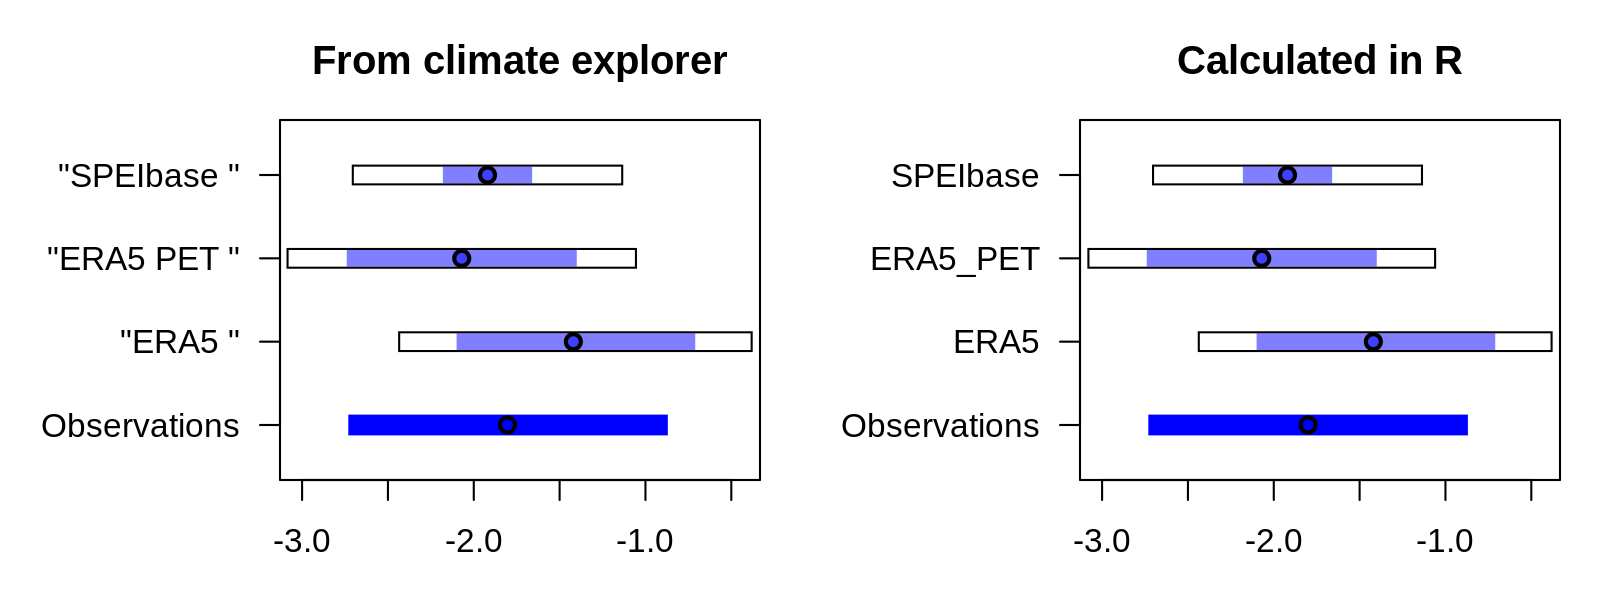

In [48]:
yy = 0:nobs

prep_window(c(1,2), h = 3, mar = c(3,7,3,1))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot(0, type = "n", xlim = range(obs_in[,c("l_wb", "u_wb")]), ylim = range(yy) + 0.5*c(-1,1), 
     xlab = "", ylab = "", yaxt = "n", main = "From climate explorer")

segments(y0 = 1:nobs, x0 = obs_out$l_wb, x1 = obs_out$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = 1:nobs, x0 = obs_out$l_wb, x1 = obs_out$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = 1:nobs, x0 = obs_out$lower, x1 = obs_out$upper, lwd = 8, col = gcols["obs"], lend = 1)
points(obs_out$est, 1:nobs, pch = 21, bg = gcols["obs"], lwd = 2)

segments(y0 = 0, x0 = obs["lower"], x1 = obs["upper"], lwd = 10, col = gcols["obs_synth"], lend = 2)
points(obs["est"], 0, pch = 21, bg = gcols["obs_synth"], lwd = 2)


axis(2, at = yy, labels = c("Observations", obs_out$model), las = 1)    

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

plot(0, type = "n", xlim = range(obs_in[,c("l_wb", "u_wb")]), ylim = range(yy) + 0.5*c(-1,1), 
     xlab = "", ylab = "", yaxt = "n", main = "Calculated in R")

segments(y0 = 1:nobs, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 10, col = "black", lend = 2)
segments(y0 = 1:nobs, x0 = obs_in$l_wb, x1 = obs_in$u_wb, lwd = 8, col = "white", lend = 2)
segments(y0 = 1:nobs, x0 = obs_in$lower, x1 = obs_in$upper, lwd = 8, col = gcols["obs"], lend = 1)
points(obs_in$est, 1:nobs, pch = 21, bg = gcols["obs"], lwd = 2)

segments(y0 = 0, x0 = obs_synth$l_wb, x1 = obs_synth$u_wb, lwd = 10, col = gcols["obs_synth"], lend = 2)
points(obs_synth["est"], 0, pch = 21, bg = gcols["obs_synth"], lwd = 2)

axis(2, at = yy, labels = c("Observations", obs_in$model), las = 1)

## Mean & uncertainties of models

Original Fortran code:
```fortran

!   compute mean & uncertainties of models
!
    call getsynmean(lweighted,data,n,nobs,sig_mod)
    if ( lwrite ) print *,'first guess of model mean is ',data(:,n+1)
    call getsynchi2(data,n,nobs,sig_mod,chi2)
    if ( lweighted ) then
        print '(a,g14.4)','# model chi2/dof = ',chi2/(n-nobs-1)
    end if
    if ( lweighted .and. .not.lnoave .and. chi2/(n-nobs-1) > 1 .and. sig_mod < 0 ) then
        ! compute sig_mod to make chi2/dof = 1
        syn_n = n ! copy to common as I am a F77 programmer and do not feel comfortable with f90 global variables
        syn_nobs = nobs
        syn_data(:,1:n) = data(:,1:n)
        s1 = 0
        s2 = data(3,n+1) - data(2,n+1)
        if ( syn_func(s1) <= 0 ) then
            write(0,*) 'synthesis: internal error: syn_func(0) should be > 0, not ',syn_func(s1)
            call exit(-1)
        end if
        s = syn_func(s2)
        do while ( s2 < 1e10 )
            s2 = 2*s2
            if ( s2 > 1e10 ) then
                write(0,*) 'synthesis: error: cannot find zero: ',s2
                call exit(-1)
            end if
            s = syn_func(s2)
            if ( s < 0 ) exit
        end do
        if ( lwrite ) print *,'bracketed sig_mod by ',s1,s2,', calling Brent'
        sig_mod = zbrent(syn_func,s1,s2,1e-4)
        !!!write(names(n)(len_trim(names(n))+1:),'(a,f4.2)') ' added ',sig_mod
        ! copy results back
        mod(1:3) = syn_data(1:3,n+1)
    else
        sig_mod = 0
        mod(1:3) = data(1:3,n+1)
    end if
    mod(4) = mod(2)
    mod(5) = mod(3)
    do i=nobs+1,n
        data(4,i) = data(1,i) - sqrt( (data(1,i)-data(2,i))**2 + sig_mod**2 )     !CB! CORRECTION NEEDED - SHOULD BE (2*sig_mod)**2
        data(5,i) = data(1,i) + sqrt( (data(3,i)-data(1,i))**2 + sig_mod**2 )
    end do
    if ( lwrite ) print *,'found combined model estimate ',mod
```


Subroutines:
```fortran
subroutine getsynmean(lweighted,data,n,nobs,sig_mod)
!
!   compute the mean of model data, either weighted with model error or unweighted
!   n is the number of input points, ..(n) denotes the average.
!
    implicit none
    logical,intent(in) :: lweighted
    integer,intent(in) :: n,nobs
    real,intent(in) :: sig_mod
    real,intent(inout) :: data(5,n+1)
    integer :: i,j
    real s1,ss2(3),w,w1
!
    s1 = 0
    ss2 = 0
    w1 = 0
    do i=nobs+1,n
        if ( lweighted ) then
            if ( abs(data(3,i) - data(2,i)) < 1e-6 ) then
                write(0,*) 'synthesis: error: upper and lower bound are equal: ',i,data(2,i),data(3,i)
                call exit(-1)
            end if
            if ( sig_mod > 0 ) then
                w = 1/((data(3,i) - data(2,i))**2 + (2*sig_mod)**2) ! factor 2 for sig_mod transforms from 2sigma to 4sigma      !CB! Ideally these weights would be inverse variances, not interval widths
            else
                w = 1/(data(3,i) - data(2,i))**2
            end if
        else
            w = 1
        end if
        w1 = w1 + w
        s1 = s1 + w*data(1,i)
        do j=2,3
            ss2(j) = ss2(j) + (w*(data(1,i)-data(j,i)))**2
        end do
    end do
    s1 = s1/w1
    do j=2,3
        ss2(j) = sqrt(ss2(j))/w1
        if ( sig_mod > 0 ) then
            ss2(j) = sqrt(ss2(j)**2 + sig_mod**2)     !CB! CORRECTION NEEDED - SHOULD BE (2*sig_mod)^2
        end if
    end do
    data(1,n+1) = s1
    data(2,n+1) = s1 - ss2(2)
    data(3,n+1) = s1 + ss2(3)
end subroutine getsynmean

subroutine getsynchi2(data,n,nobs,sig_mod,chi2)
!
!   compute chi2
!
    implicit none
    integer,intent(in) :: n,nobs
    real,intent(in) :: data(5,n+1)
    real,intent(out) :: sig_mod,chi2
    integer :: i
    real :: s1

    chi2 = 0
    s1 = data(1,n+1)
    do i=nobs+1,n
        if ( sig_mod > 0 ) then
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + (data(1,i)-s1)**2/((data(1,i)-data(2,i))**2 + sig_mod**2)     !CB! CORRECTION NEEDED (FORM TBD)
            else
                chi2 = chi2 + (s1-data(1,i))**2/((data(3,i)-data(1,i))**2 + sig_mod**2)
            end if
        else
            if ( data(1,i) > s1 ) then
                chi2 = chi2 + ((data(1,i)-s1)/(data(1,i)-data(2,i)))**2
            else
                chi2 = chi2 + ((s1-data(1,i))/(data(3,i)-data(1,i)))**2
            end if
        end if
    end do
    chi2 = chi2*4 ! transformed to use 95%~2sigma CIs                                       !CB! REMEMBER TO REMOVE WHEN FIXING CHI^2 CALCULATION
end subroutine getsynchi2
```

### Replicate climate explorer output

Original functions, no changes made

In [152]:
getsynmean <- function(data, sig_mod = -1) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [153]:
getsynchi2 <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_adj^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_adj^2)
        }
    }))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

In [154]:
modelsynth <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean(models_in, sig_mod = 0)
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### Correct interval widths in model weighting

- add factor of 2 to sigmod when estimating upper & lower bounds

In [155]:
getsynmean_fixwidth <- function(data, sig_mod = 0) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + (2*sig_mod)^2) }  ## CORRECTION - THIS SHOULD BE (2*sig_mod)^2
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [156]:
modelsynth_fixwidth <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean_fixwidth(models_in, sig_mod = 0)
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean_fixwidth(models_in, sig_mod = sigmod)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### $\chi^2$ is missing factor of 2 to convert sigmod to interval

- don't recommend doing this one - better to use variances and so replicated the intended equation

In [161]:
getsynchi2_fixchi2interval <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on model intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + (2*sig_adj)^2)
        } else {
            (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + (2*sig_adj)^2)
        }
    }))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    return(chi2)
}

In [162]:
modelsynth_fixchi2interval <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean(models_in, sig_mod = 0)
    chi2 <- getsynchi2_fixchi2interval(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2_fixchi2interval(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### $\chi^2$ should use variances, not intervals
- my preferred approach to estimating $chi^2$, since it means this is a ratio of two variances, rather than a variance and an interval as it currently is

In [175]:
getsynchi2_usevariances <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean(data, sig_mod)["est"]
       
    # # compute chi2 based on model intervals & sigma adjustment
    # chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    #     if(x["est"] > s1) {
    #         (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_mod^2)
    #     } else {
    #         (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_mod^2)
    #     }
    # }))
    # chi2 = chi2 * 4 # transform to give 95%~2sigma CIs 
    
    # compute chi2 based on variances rather than intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
        } else {
            (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
        }
    }))
    # no longer necessary to inflate by 4
    return(chi2)
}

In [164]:
modelsynth_usevariances <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean(models_in, sig_mod = 0)
    chi2 <- getsynchi2_usevariances(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2_usevariances(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean(models_in, sig_mod = sigmod)
    
    # add representation error to observations
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### Necessary modifications

In [219]:
getsynmean_necessary <- function(data, sig_mod = -1) {    
    
    # calculate weight for each model (based on width of confidence interval)
    if ( sig_mod > 0 ) {
        w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    } else {
        w = 1/(data$upper - data$lower)^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + (2*sig_mod)^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [220]:
getsynchi2_necessary <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean_necessary(data, sig_mod)["est"]
       
    # # compute chi2 based on model intervals & sigma adjustment
    # chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
    #     if(x["est"] > s1) {
    #         (x["est"] - s1)^2 / ((x["est"] - x["lower"])^2 + sig_mod^2)
    #     } else {
    #         (x["est"] - s1)^2 / ((x["est"] - x["upper"])^2 + sig_mod^2)
    #     }
    # }))
    # chi2 = chi2 * 4 # transform to give 95%~2sigma CIs 
    
    # compute chi2 based on variances rather than intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
        } else {
            (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
        }
    }))
    # no longer necessary to inflate by 4
    return(chi2)
}

In [221]:
modelsynth_necessary <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean_necessary(models_in, sig_mod = 0)
    chi2 <- getsynchi2_necessary(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2_necessary(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean_necessary(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### Query: use optimum weighting instead of interval weighting?

In [242]:
getsynmean_optweights <- function(data, sig_mod = 0) {    
    
    # # calculate weight for each model (based on width of confidence interval)
    # if ( sig_mod > 0 ) {
    #     w = 1/((data$upper - data$lower)^2 + (2*sig_mod)^2) # factor 2 for sig_mod transforms from 2sigma to 4sigma
    # } else {
    #     w = 1/(data$upper - data$lower)^2
    # }
    # calculate weight for each model (based on inverse variances)
    if ( sig_mod > 0 ) {
        w = 1/(((data$upper - data$lower)/(2*1.96))^2 + sig_mod^2)
    } else {
        w = 1/((data$upper - data$lower)/(2*1.96))^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                 
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + sig_mod^2) }
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [223]:
modelsynth_optweights <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean_optweights(models_in, sig_mod = 0)
    chi2 <- getsynchi2(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean_optweights(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + sigmod**2)
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + sigmod**2)
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### Suggested corrections
- add factor of 2 to sigmod when estimating upper & lower bounds
- calculate $\chi^2$ based on ratio of variances, rather than ratio of variance to interval
- model weights based on inverse variances, rather than inverse confidence intervals

In [224]:
getsynmean_suggested <- function(data, sig_mod = 0) {    
    
    # calculate weight for each model (based on inverse variances)
    if ( sig_mod > 0 ) {
        w = 1/(((data$upper - data$lower)/(1.96*2))^2 + sig_mod^2)
    } else {
        w = 1/((data$upper - data$lower)/(1.96*2))^2
    }
    w1 = sum(w)

    # weighted sum of squares & bounds
    s1 <- sum(w*data$est) / w1
    ss2 <- apply(data[,c("est", "lower", "upper")], 2, function(b) sum((w*(data$est - b))^2))
    ss2 <- sqrt(ss2) / w1
                     
    if (sig_mod > 0) { ss2 <- sqrt(ss2^2 + (2*sig_mod)^2) }  ## CORRECTION - THIS SHOULD BE (2*sig_mod)^2
    
    return(s1 + (ss2 * c(0,-1,1)))
}

In [225]:
getsynchi2_suggested <- function(data, sig_mod) {
    
    # get best estimate of weighted mean
    s1 <- getsynmean_suggested(data, sig_mod)["est"]
    
    # determine adjustment to sigma, if any
    if(sig_mod < 0) {sig_adj = 0} else {sig_adj = sig_mod}
    
    # compute chi2 based on variances rather than intervals & sigma adjustment
    chi2 <- sum(apply(data[,c("est", "lower", "upper")], 1, function(x) {
        if(x["est"] > s1) {
            (x["est"] - s1)^2 / (((x["est"] - x["lower"])/1.96)^2 + sig_mod^2)
        } else {
            (x["est"] - s1)^2 / (((x["est"] - x["upper"])/1.96)^2 + sig_mod^2)
        }
    }))
    return(chi2)
}

In [244]:
modelsynth_suggested <- function(models_in) {
    
    # get initial estimate of model mean & calculate chi^2
    mmean_1 <- getsynmean_suggested(models_in, sig_mod = 0)
    chi2 <- getsynchi2_suggested(models_in, sig_mod = 0)
    mdof <- nrow(models_in)-1
    
    # estimate sig_mod such that chi^2/dof = 1
    sigmod <- optim(0, function(x) {(getsynchi2_suggested(models_in, sig_mod = x) - (nrow(models_in)-1))^2}, method = "Brent", lower = 0, upper = 5)$par
    
    # weighted model mean
    models <- getsynmean_suggested(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_in$l_wb <- models_in$est - sqrt((models_in$est - models_in$lower)**2 + (2*sigmod)**2)     ## ALSO NEED TO CORRECT THIS TO ADD (2*sigmod)^2
    models_in$u_wb <- models_in$est + sqrt((models_in$est - models_in$upper)**2 + (2*sigmod)**2)     ## ALSO NEED TO CORRECT THIS TO ADD (2*sigmod)^2
    
    return(list(models = models_in, models_synth = models, chi2dof = chi2/mdof, sigmod = sigmod))
}

### Compare results
- most important thing is to fix the weighting interval in `getsynmean`, which is currently underestimated by $2\sigma_{obs}^2$
- also need to fix chi^2 interval somehow - both approaches produce similar results but suggest converting to variance, removes need for 'fudge factor'
- using optimal model weights has very little effect in this example - but does also change the best estiate

In [245]:
models_climexp <- modelsynth(models_in)                           # standard method, no adjustments to ClimExp code
models_fixwidth <- modelsynth_fixwidth(models_in)                 # necessary: correct interval widths in model weighting

models_fixchi2interval <- modelsynth_fixchi2interval(models_in)   # not recommended to fix chi^2 interval: add factor of 2 in chi^2 but don't use variances
models_usevariances <- modelsynth_usevariances(models_in)         # necessary in some form to fix chi^2 interval: correct interval widths in model weighting

models_necessary <- modelsynth_necessary(models_in)               # both necessary changes: fix interval used in synmean weighting and in chi^2 calculation

models_optweights <- modelsynth_optweights(models_in)             # suggested: use variances to weight models instead of interval widths
models_suggested <- modelsynth_suggested(models_in)               # suggested: use variances to weight models instead of interval widths, use variances for chi^2, and fix interval used in synmean weighting

In [246]:
models_synth <- sapply(rev(list("ClimExp" = models_climexp, "Fix weight interval" = models_fixwidth, "Adjust chi2 interval" = models_fixchi2interval,
                                "Use variances in chi2" = models_usevariances, "Necessary changes" = models_necessary,
                                "Optimal weights" = models_optweights, "Suggested" = models_suggested)), "[[", "models_synth")
models_synth

,Suggested,Optimal weights,Necessary changes,Use variances in chi2,Adjust chi2 interval,Fix weight interval,ClimExp
est,-1.644204,-1.650799,-1.620930,-1.6209295,-1.6209591,-1.644555,-1.644555
lower,-5.626199,-5.634807,-5.603085,-3.6294479,-3.6304530,-9.594621,-5.628508
upper,2.338718,2.334136,2.362146,0.3894124,0.3903574,6.305975,2.340323


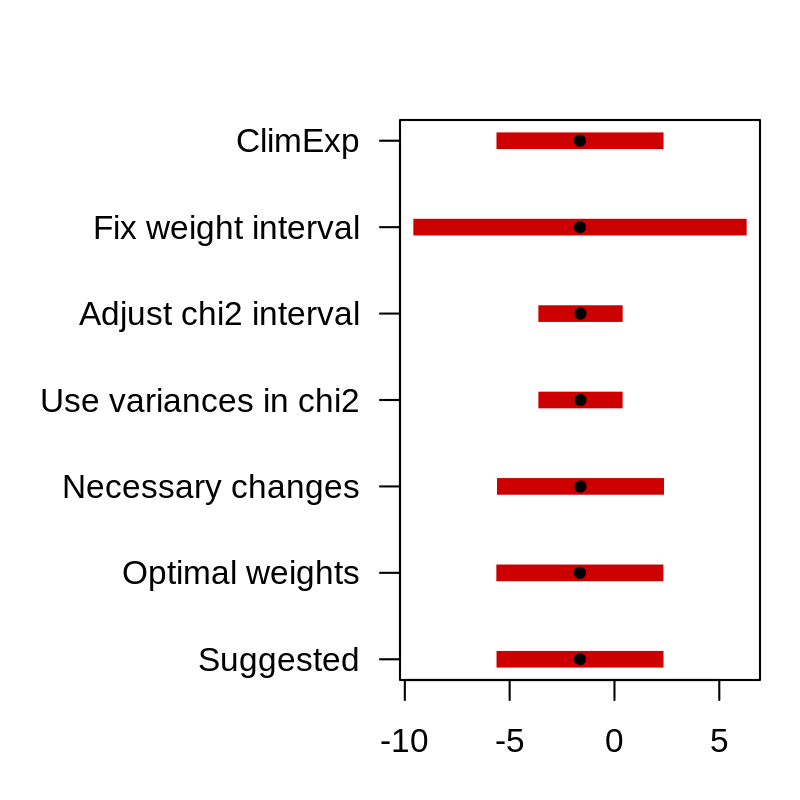

In [247]:
prep_window(c(1,1), mar = c(3,10,3,1))

plot(0, type = "n", xlim = range(models_synth), ylim = c(1, ncol(models_synth)), xlab = "", ylab = "", yaxt = "n")
segments(y0 = 1:ncol(models_synth), x0 = models_synth["lower",], x1 = models_synth["upper",], lwd = 8, col = "red3", lend = 1)
points(models_synth["est",], 1:ncol(models_synth))


axis(2, at = 1:ncol(models_synth), labels = colnames(models_synth), las = 1)

## Synthesis

```fortran
!   compute synthesis: weighted average of obervations and models
!
    if ( nobs > 0 ) then
        if ( obs(2) >= obs(3) ) then
            write(0,*) 'synthesis: internal error: obs = ',obs
            call exit(-1)
        end if
        if ( mod(2) >= mod(3) ) then
            write(0,*) 'synthesis: internal error: mod = ',mod
            call exit(-1)
        end if
        if ( lweighted ) then
            ! weighted mean coloured
            w1 = 1/(obs(3)-obs(2))**2
            w2 = 1/(mod(3)-mod(2))**2
            syn(1) = (w1*obs(1) + w2*mod(1))/(w1+w2)
            syn(2) = syn(1) - sqrt( (w1*(obs(1)-obs(2)))**2 + (w2*(mod(1)-mod(2)))**2 )/(w1+w2)
            syn(3) = syn(1) + sqrt( (w1*(obs(3)-obs(1)))**2 + (w2*(mod(3)-mod(1)))**2 )/(w1+w2)
            ! unweighted mean of observations and models box
            s1 = (obs(1) + mod(1))/2
            syn(4) = s1 - sqrt( (obs(1)-obs(2))**2 + (mod(1)-mod(2))**2 )/2
            syn(5) = s1 + sqrt( (obs(3)-obs(1))**2 + (mod(3)-mod(1))**2 )/2
        else
            call getsynmean(lweighted,data,n,0,sig_mod)
            syn(1:3) = data(1:3,n+1)
            syn(4) = syn(2)
            syn(5) = syn(3)
        end if
        if ( lwrite ) print *,'found synthesised estimate ',syn
    end if
```


### Replicate climate explorer output

Original functions, no changes made

In [231]:
synth_climexp <- function(obs, models) {
    # weighted mean of models & obs (coloured bar)
    w_obs <- unname((obs["upper"] - obs["lower"])^{-2})
    w_mod <- unname((models["upper"] - models["lower"])^{-2})

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
    synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2
    
    return(synth)
}

In [232]:
synth_variances <- function(obs, models) {
    
    # weighted mean of models & obs (coloured bar)
    w_obs <- unname(((obs["upper"] - obs["lower"])/1.96*2)^{-2})
    w_mod <- unname(((models["upper"] - models["lower"])/1.96*2)^{-2})

    wmean <- (w_obs * obs["est"] + w_mod * models["est"]) / (w_obs + w_mod)
    synth <- setNames(c(wmean, 
                        wmean - sqrt( (w_obs*(obs["est"]-obs["lower"]))^2 + (w_mod*(models["est"]-models["lower"]))^2 )/(w_obs+w_mod),
                        wmean + sqrt( (w_obs*(obs["est"]-obs["upper"]))^2 + (w_mod*(models["est"]-models["upper"]))^2 )/(w_obs+w_mod)), c("est", "lower", "upper"))

    # unweighted mean of obs and models
    umean <- (obs["est"] +  models["est"]) / 2
    synth["l_wb"] <- umean - sqrt((obs["est"]-obs["lower"])^2 + (models["est"]-models["lower"])^2)/2
    synth["u_wb"] <- umean + sqrt((obs["est"]-obs["upper"])^2 + (models["est"]-models["upper"])^2)/2
    
    return(synth)
}

In [233]:
# identical results - don't think we need to change anything here
synth_climexp(obs, models_climexp$models_synth)
synth_variances(obs, models_climexp$models_synth)

est      lower      upper       l_wb       u_wb 
-1.7961091 -2.6430957 -0.9433069 -3.7625237  0.3157515

est      lower      upper       l_wb       u_wb 
-1.7961091 -2.6430957 -0.9433069 -3.7625237  0.3157515